In [53]:
import numpy as np
from scipy.sparse.linalg import cg
from scipy.sparse import diags
import matplotlib.pyplot as plt
from scipy.sparse import identity
from scipy.sparse.linalg import onenormest
import time as time

## Using the Scipy conjugate gradient method

In [48]:
n = 500


#this makes the matrix A positive definite symmetric
Q, _ = np.linalg.qr(np.random.randn(n, n))
D = np.diag(np.random.rand(n))
A = Q.T @ D @ Q

In [49]:
b = np.random.rand(n)
residuals = []

callback = lambda x: residuals.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))

sol, _ = cg(A, b, tol=1E-10, callback=callback, maxiter=1000)

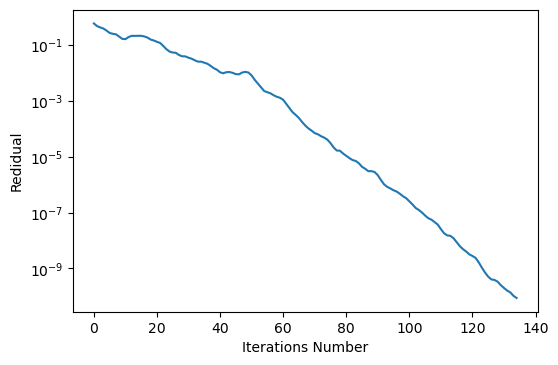

In [50]:
plt.figure(dpi=100)
plt.plot(np.arange(0,len(residuals)),residuals)
plt.xlabel('Iterations Number')
plt.ylabel('Redidual')
#plt.xscale('log')
plt.yscale('log')

## Code from the notes

In [30]:
n = 10000

data = [2.1 * np.ones(n),
        -1. * np.ones(n - 1),
        -1. * np.ones(n - 1)]

#print('Data: \n',data)

offsets = [0, 1, -1]

#print('Offsets: \n',offsets)

A = diags(data, offsets=offsets, shape=(n, n), format='csr')

#print('A: \n',A)

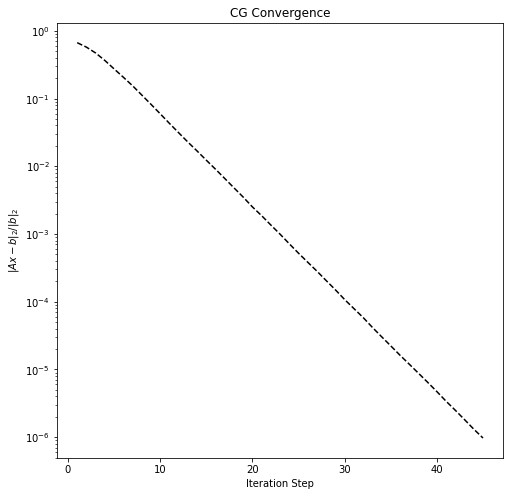

In [34]:
b = np.random.randn(n)
residuals = []

callback = lambda x: residuals.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))

sol, _ = cg(A, b, tol=1E-6, callback=callback, maxiter=1000)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.semilogy(1 + np.arange(len(residuals)), residuals, 'k--')
ax.set_title('CG Convergence')
ax.set_xlabel('Iteration Step')
_ = ax.set_ylabel('$\|Ax-b\|_2 / \|b\|_2$')



In [27]:
num = 3
x = np.linspace(0,1,num*2)
x = x.reshape((2,num))
print(x,'\n')
m = diags(x,format='dense',offsets=[1,-1])
print(m)

[[0.  0.2 0.4]
 [0.6 0.8 1. ]] 

[[0.  0.  0.  0. ]
 [0.6 0.  0.2 0. ]
 [0.  0.8 0.  0.4]
 [0.  0.  1.  0. ]]


## Applying the SPAI technique

In [9]:
def spai(A, m):
    """Perform m step of the SPAI iteration."""
    
    n = A.shape[0]
    
    ident = identity(n, format='csr')
    alpha = 2 / onenormest(A @ A.T)
    M = alpha * A
        
    for index in range(m):
        C = A @ M
        G = ident - C
        AG = A @ G
        trace = (G.T @ AG).diagonal().sum()
        alpha = trace / np.linalg.norm(AG.data)**2
        M = M + alpha * G
        
    return M

In [27]:
m = 50
M = spai(A, m)
print(np.linalg.cond(A))
print(np.linalg.cond(A@M))

1670.6975327544221
17.48906720885852


In [41]:
residuals2 = []
callback2 = lambda x: residuals2.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))

sol2, _ = cg(A, b, M=M, tol=1E-10, callback=callback2, maxiter=1000)

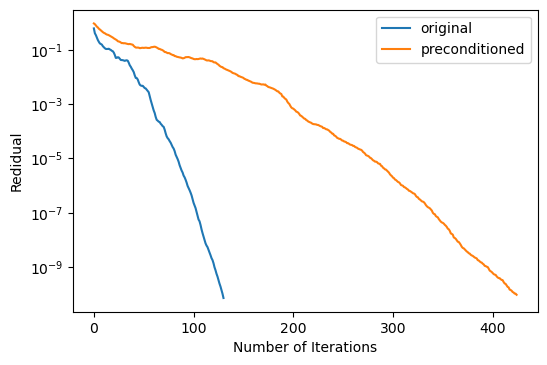

In [42]:
plt.figure(dpi=100)
plt.plot(np.arange(0,len(residuals)),residuals, label='original')
plt.plot(np.arange(0,len(residuals2)),residuals2, label='preconditioned')
plt.xlabel('Number of Iterations')
plt.ylabel('Redidual')
#plt.xscale('log')
plt.yscale('log')
plt.legend()

### Exploring effect of m on preconditioning strength

Time taken to calculate preconditioner and perform cg for each m value:
10 : 0.147 secs
100 : 1.454 secs
1000 : 16.67 secs


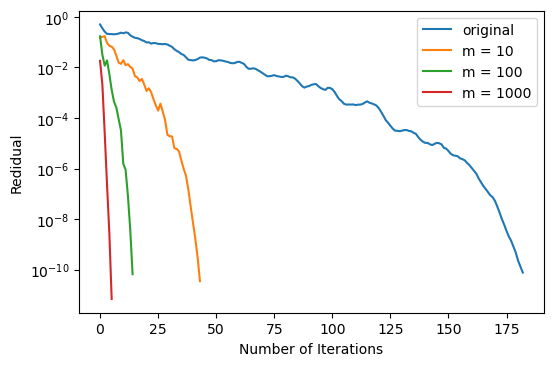

In [57]:
n = 500


#performing CG method on original A
Q, _ = np.linalg.qr(np.random.randn(n, n))
D = np.diag(np.random.rand(n))
A = Q.T @ D @ Q
b = np.random.rand(n)
residuals = []
callback = lambda x: residuals.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))
sol, _ = cg(A, b, tol=1E-10, callback=callback, maxiter=1000)




m_vals = np.logspace(1,3,3,dtype='int')

#plotting and performing CG method on preconditioned A
plt.figure(dpi=100)
plt.plot(np.arange(0,len(residuals)),residuals, label='original')
print('Time taken to calculate preconditioner and perform cg for each m value:')

for i, m in enumerate(m_vals):
    residuals2 = []
    start = time.time()
    M = spai(A, m)
    startcg = time.time()
    sol2, _ = cg(A, b, M=M, tol=1E-10, callback=callback2, maxiter=1000)
    end = time.time()
    print(m,':',np.round(end-start,decimals=3),'secs')
    plt.plot(np.arange(0,len(residuals2)),residuals2, label=f'm = {m}')
plt.xlabel('Number of Iterations')
plt.ylabel('Redidual')
#plt.xscale('log')
plt.yscale('log')
plt.legend()